> **Problem overview**

In this playground competition, hosted in partnership with Google Cloud and Coursera, you are tasked with predicting the fare amount (inclusive of tolls) for a taxi ride in New York City given the pickup and dropoff locations. While you can get a basic estimate based on just the distance between the two points, this will result in an RMSE of $5-$8, depending on the model used (see the starter code for an example of this approach in Kernels). Your challenge is to do better than this using Machine Learning techniques!

To learn how to handle large datasets with ease and solve this problem using TensorFlow, consider taking the Machine Learning with TensorFlow on Google Cloud Platform specialization on Coursera -- the taxi fare problem is one of several real-world problems that are used as case studies in the series of courses. To make this easier, head to Coursera.org/NEXTextended to claim this specialization for free for the first month!

In [1]:
# import python standard library
import math

# import data manipulation library
import numpy as np
import pandas as pd

# import data visualization library
import matplotlib.pyplot as plt
import seaborn as sns

# import model function from sklearn
from sklearn.ensemble import RandomForestRegressor

# import sklearn model selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# import sklearn model evaluation regression metrics
from sklearn.metrics import mean_squared_error

> **Acquiring training and testing data**

We start by acquiring the training and testing datasets into Pandas DataFrames.

In [2]:
# acquiring training and testing data
df_train = pd.read_csv('../input/train.csv', nrows=2000000, parse_dates=['pickup_datetime'])
df_test = pd.read_csv('../input/test.csv', parse_dates=['pickup_datetime'])

In [3]:
# visualize head of the training data
df_train.head(n=3)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2


In [4]:
# visualize tail of the testing data
df_test.tail(n=3)

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
9911,2015-04-19 20:44:15.0000001,2015-04-19 20:44:15,-73.991600,40.726608,-73.789742,40.647011,6
9912,2015-01-31 01:05:19.0000005,2015-01-31 01:05:19,-73.985573,40.735432,-73.939178,40.801731,6
9913,2015-01-18 14:06:23.0000006,2015-01-18 14:06:23,-73.988022,40.754070,-74.000282,40.759220,6


In [5]:
# combine training and testing dataframe
df_train['datatype'], df_test['datatype'] = 'training', 'testing'
df_test.insert(1, 'fare_amount', 0)
df_data = pd.concat([df_train, df_test], ignore_index=True)

> **Feature exploration, engineering and cleansing**

Here we generate descriptive statistics that summarize the central tendency, dispersion and shape of a dataset’s distribution together with exploring some data.

In [6]:
def scatterplot(numerical_x: list or str, numerical_y: list or str, data: pd.DataFrame, figsize: tuple = (4, 3), ncols: int = 5, nrows: int = None) -> plt.figure:
    """ Return a scatter plot applied for numerical variable in x-axis vs numerical variable in y-axis.
    
    Args:
        numerical_x (list or str): The numerical variable in x-axis.
        numerical_y (list or str): The numerical variable in y-axis.
        data (pd.DataFrame): The data to plot.
        figsize (tuple): The matplotlib figure size width and height in inches. Default to (4, 3).
        ncols (int): The number of columns for axis in the figure. Default to 5.
        nrows (int): The number of rows for axis in the figure. Default to None.
    
    Returns:
        plt.figure: The plot figure.
    """
    
    numerical_x, numerical_y = [numerical_x] if type(numerical_x) == str else numerical_x, [numerical_y] if type(numerical_y) == str else numerical_y
    if nrows is None: nrows = (len(numerical_x)*len(numerical_y) - 1) // ncols + 1
    
    fig, axes = plt.subplots(figsize=(figsize[0]*ncols , figsize[1]*nrows), ncols=ncols, nrows=nrows)
    axes = axes.flatten()
    _ = [sns.scatterplot(x=vj, y=vi, data=data, ax=axes[i*len(numerical_x) + j], rasterized=True) for i, vi in enumerate(numerical_y) for j, vj in enumerate(numerical_x)]
    return fig

In [7]:
def distance(lat1: float, lon1: float, lat2: float, lon2: float) -> float:
    """ Return the distance between 2 points of latitude and longitude.
    
    Args:
        lat1 (float): The latitude of the first coordinate.
        lon1 (float): The longitude of the first coordinate.
        lat2 (float): The latitude of the second coordinate.
        lon2 (float): The longitude of the second coordinate.
    
    Returns:
        float: The distance between 2 points of latitude and longitude.
    """
    angle = 0.017453292519943295 #math.pi / 180
    x = 0.5 - np.cos((lat2 - lat1) * angle) / 2 + np.cos(lat1 * angle) * np.cos(lat2 * angle) * (1 - np.cos((lon2 - lon1) * angle)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(x))

In [8]:
# describe training and testing data
df_data.describe(include='all')

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,datatype
count,2009914,2.009914e+06,2009914,2.009914e+06,2.009914e+06,2.009900e+06,2.009900e+06,2.009914e+06,2009914
unique,2009914,NaN,1640019,NaN,NaN,NaN,NaN,NaN,2
top,2013-06-01 19:25:00.000000225,NaN,2011-12-13 22:00:00,NaN,NaN,NaN,NaN,NaN,training
freq,1,NaN,270,NaN,NaN,NaN,NaN,NaN,2000000
first,NaN,NaN,2009-01-01 00:00:46,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2015-06-30 23:53:49,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.129182e+01,NaN,-7.253037e+01,3.993368e+01,-7.253110e+01,3.993214e+01,1.684050e+00,NaN
std,NaN,9.860654e+00,NaN,1.283667e+01,7.963847e+00,1.274383e+01,1.029848e+01,1.314806e+00,NaN
min,NaN,-6.200000e+01,NaN,-3.377681e+03,-3.458665e+03,-3.383297e+03,-3.461541e+03,0.000000e+00,NaN
25%,NaN,6.000000e+00,NaN,-7.399208e+01,4.073492e+01,-7.399141e+01,4.073400e+01,1.000000e+00,NaN


In [9]:
# list all features type number
col_number = df_data.select_dtypes(include=['number']).columns.tolist()
print('features type number:\n items %s\n length %d' %(col_number, len(col_number)))

# list all features type object
col_object = df_data.select_dtypes(include=['object']).columns.tolist()
print('features type object:\n items %s\n length %d' %(col_object, len(col_object)))

features type number:
 items ['fare_amount', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count']
 length 6
features type object:
 items ['key', 'datatype']
 length 2


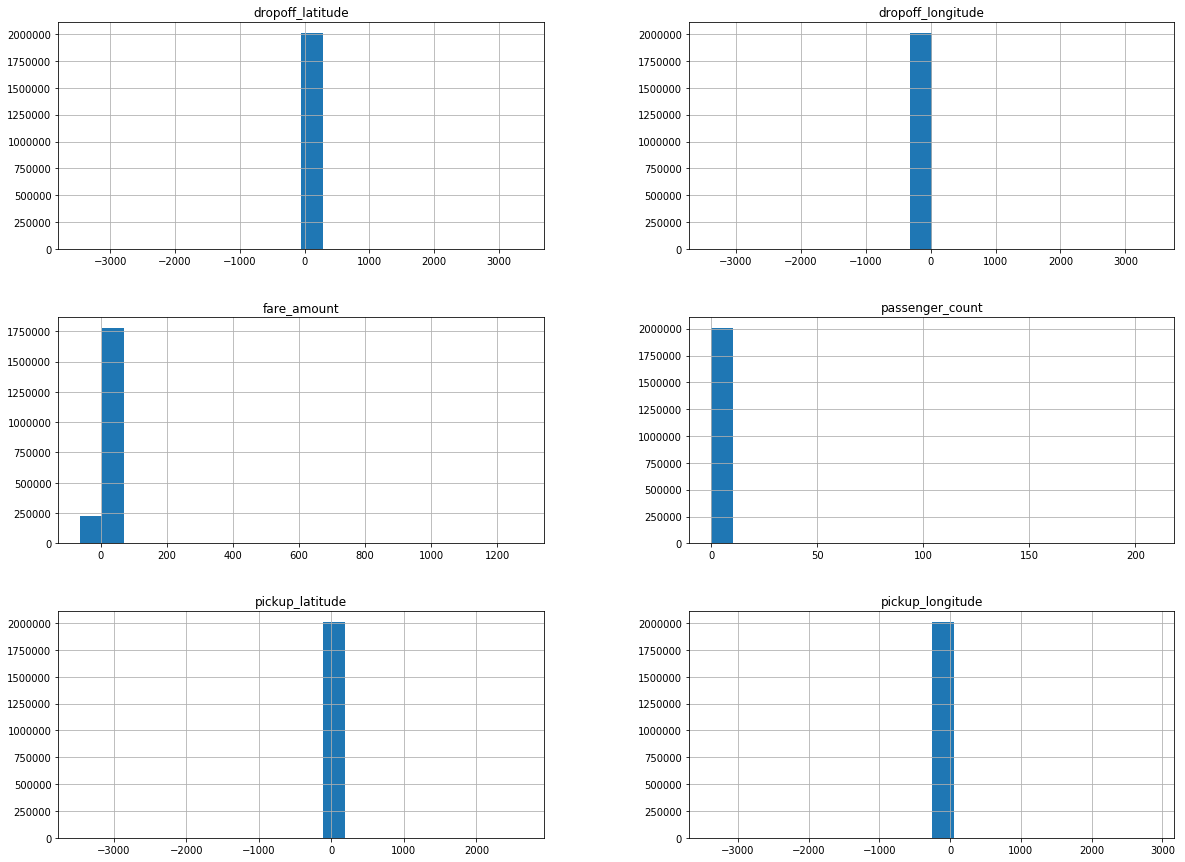

In [10]:
# feature exploration: histogram of all numeric features
_ = df_data.hist(bins=20, figsize=(20, 15))

In [11]:
# feature extraction: fare amount
df_data['fare_amount'] = np.log1p(df_data['fare_amount'])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log1p
  


In [12]:
# feature extraction: combination of keyword date
df_data['year'] = df_data['pickup_datetime'].dt.year
df_data['quarter'] = df_data['pickup_datetime'].dt.quarter
df_data['month'] = df_data['pickup_datetime'].dt.month
df_data['weekofyear'] = df_data['pickup_datetime'].dt.weekofyear
df_data['weekday'] = df_data['pickup_datetime'].dt.weekday
df_data['dayofweek'] = df_data['pickup_datetime'].dt.dayofweek
df_data['hour'] = df_data['pickup_datetime'].dt.hour

In [13]:
# feature extraction: distance
df_data['distance_euclidean'] = distance(df_data['pickup_latitude'], df_data['pickup_longitude'], \
                                         df_data['dropoff_latitude'], df_data['dropoff_longitude'])
df_data['distance_latitude'] = df_data['dropoff_latitude'] - df_data['pickup_latitude']
df_data['distance_longitude'] = df_data['dropoff_longitude'] - df_data['pickup_longitude']

In [14]:
# feature extraction: distance to specific location
nyc = (40.7128, -74.0060)
jfk = (40.6413, -73.7781)
ewr = (40.6895, -74.1745)
df_data['distance_pickup_to_nyc'] = distance(df_data['pickup_latitude'], df_data['pickup_longitude'], nyc[0], nyc[1])
df_data['distance_pickup_to_jfk'] = distance(df_data['pickup_latitude'], df_data['pickup_longitude'], jfk[0], jfk[1])
df_data['distance_pickup_to_ewr'] = distance(df_data['pickup_latitude'], df_data['pickup_longitude'], ewr[0], ewr[1])
df_data['distance_dropoff_to_nyc'] = distance(df_data['dropoff_latitude'], df_data['dropoff_longitude'], nyc[0], nyc[1])
df_data['distance_dropoff_to_jfk'] = distance(df_data['dropoff_latitude'], df_data['dropoff_longitude'], jfk[0], jfk[1])
df_data['distance_dropoff_to_ewr'] = distance(df_data['dropoff_latitude'], df_data['dropoff_longitude'], ewr[0], ewr[1])

In [15]:
# feature extraction: fare amount per mile
df_data['fare_per_mile'] = df_data['fare_amount'] / df_data['distance_euclidean']
df_data['fare_per_mile'] = df_data['fare_per_mile'].apply(lambda x: 0 if x == float('inf') else x)
df_data['fare_per_mile'] = df_data['fare_per_mile'].fillna(0)

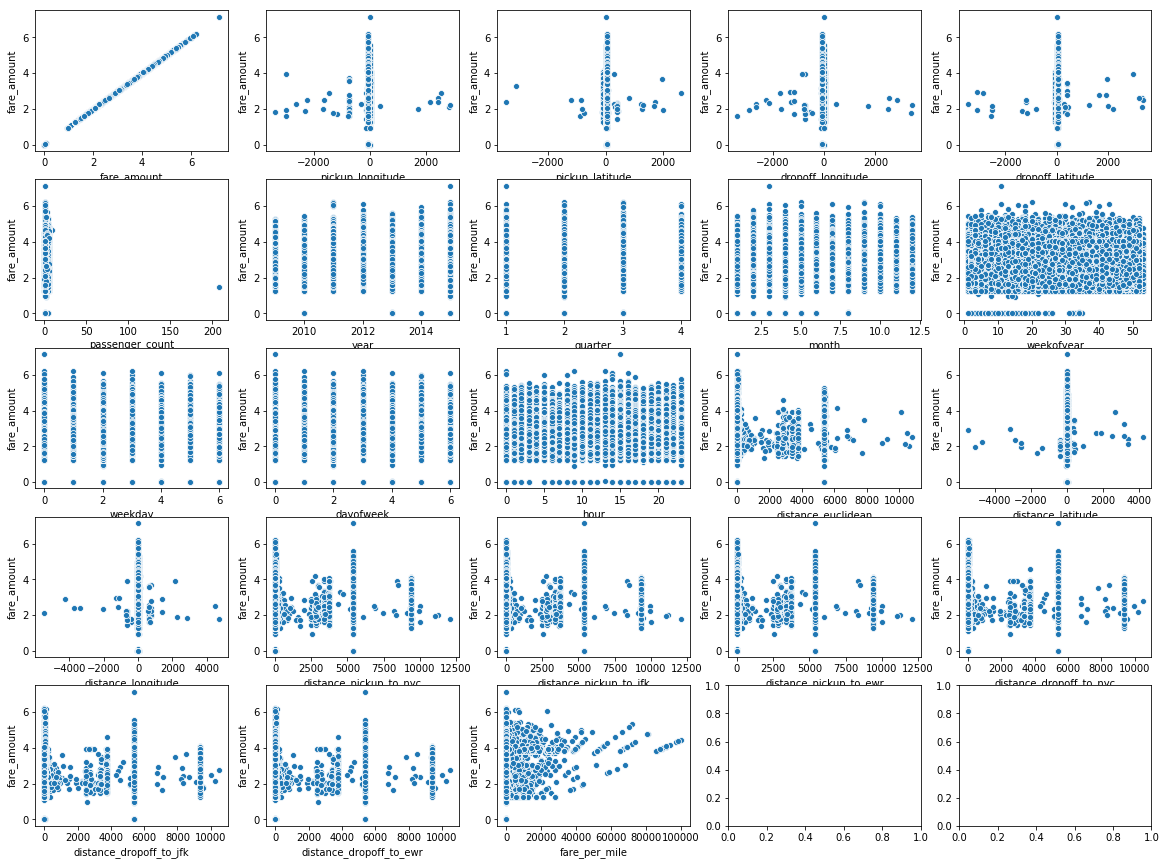

In [16]:
# feature exploration: fare amount
col_number = df_data.select_dtypes(include=['number']).columns.tolist()
_ = scatterplot(col_number, 'fare_amount', df_data[df_data['datatype'] == 'training'])

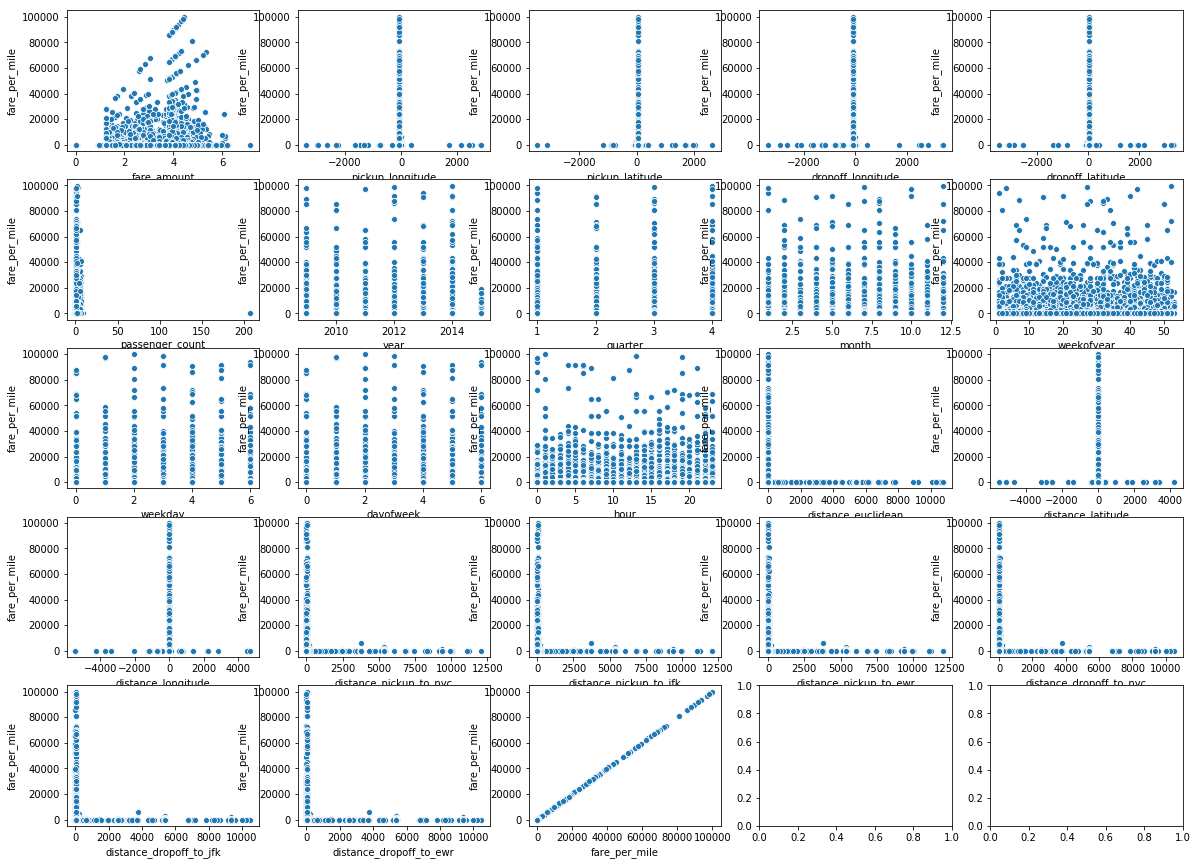

In [17]:
# feature exploration: fare per mile
col_number = df_data.select_dtypes(include=['number']).columns.tolist()
_ = scatterplot(col_number, 'fare_per_mile', df_data[df_data['datatype'] == 'training'])

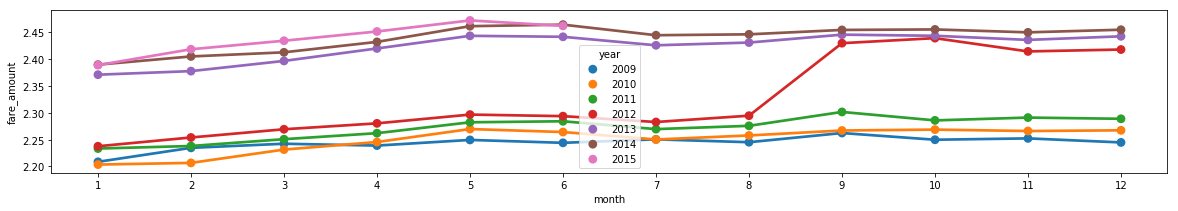

In [18]:
# feature exploration: season dataframe
df_season = df_data[df_data['datatype'] == 'training'].groupby(['year', 'month'], as_index=False).agg({
    'fare_amount': 'mean'
})
fig, axes = plt.subplots(figsize=(20, 3))
_ = sns.pointplot(x='month', y='fare_amount', data=df_season, join=True, hue='year')

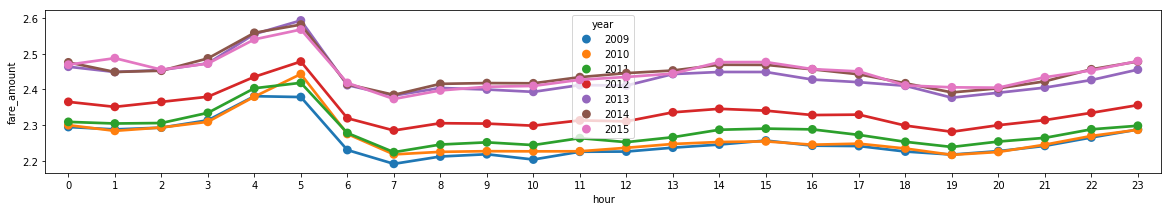

In [19]:
# feature exploration: season dataframe
df_season = df_data[df_data['datatype'] == 'training'].groupby(['year', 'hour'], as_index=False).agg({
    'fare_amount': 'mean'
})
fig, axes = plt.subplots(figsize=(20, 3))
_ = sns.pointplot(x='hour', y='fare_amount', data=df_season, join=True, hue='year')

In [20]:
# feature extraction: drop na
df_data = df_data.dropna()

After extracting all features, it is required to convert category features to numerics features, a format suitable to feed into our Machine Learning models.

In [21]:
# convert category codes for data dataframe
df_data = pd.get_dummies(df_data, columns=['datatype'], drop_first=True)

In [22]:
# describe data dataframe
df_data.describe(include='all')

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,quarter,month,weekofyear,weekday,dayofweek,hour,distance_euclidean,distance_latitude,distance_longitude,distance_pickup_to_nyc,distance_pickup_to_jfk,distance_pickup_to_ewr,distance_dropoff_to_nyc,distance_dropoff_to_jfk,distance_dropoff_to_ewr,fare_per_mile,datatype_training
count,2009823,2.009823e+06,2009823,2.009823e+06,2.009823e+06,2.009823e+06,2.009823e+06,2.009823e+06,2.009823e+06,2.009823e+06,2.009823e+06,2.009823e+06,2.009823e+06,2.009823e+06,2.009823e+06,2.009823e+06,2.009823e+06,2.009823e+06,2.009823e+06,2.009823e+06,2.009823e+06,2.009823e+06,2.009823e+06,2.009823e+06,2.009823e+06,2.009823e+06
unique,2009823,NaN,1639932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2013-06-01 19:25:00.000000225,NaN,2011-12-13 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,270,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,NaN,NaN,2009-01-01 00:00:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2015-06-30 23:53:49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2.321374e+00,NaN,-7.253045e+01,3.993373e+01,-7.253130e+01,3.993225e+01,1.684059e+00,2.011740e+03,2.423962e+00,6.270703e+00,2.547011e+01,3.040781e+00,3.040781e+00,1.350811e+01,1.207470e+01,-1.477955e-03,-8.459834e-04,1.097817e+02,1.188538e+02,1.177225e+02,1.097687e+02,1.187289e+02,1.176505e+02,1.446905e+01,9.950672e-01
std,NaN,5.706400e-01,NaN,1.283655e+01,7.963826e+00,1.274335e+01,1.029841e+01,1.314800e+00,1.860276e+00,1.115938e+00,3.436593e+00,1.494745e+01,1.950111e+00,1.950111e+00,6.517532e+00,2.278532e+02,1.006419e+01,9.482604e+00,7.599741e+02,7.569625e+02,7.599938e+02,7.594606e+02,7.564663e+02,7.594884e+02,5.361213e+02,7.006028e-02
min,NaN,0.000000e+00,NaN,-3.377681e+03,-3.458665e+03,-3.383297e+03,-3.461541e+03,0.000000e+00,2.009000e+03,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-5.486099e+03,-5.448388e+03,1.175332e-02,7.508403e-02,1.697971e-01,1.163972e-02,9.168380e-02,1.622388e-01,0.000000e+00,0.000000e+00
25%,NaN,1.945910e+00,NaN,-7.399208e+01,4.073492e+01,-7.399141e+01,4.073400e+01,1.000000e+00,2.010000e+03,1.000000e+00,3.000000e+00,1.300000e+01,1.000000e+00,1.000000e+00,9.000000e+00,7.538478e-01,-1.373300e-02,-1.126550e-02,2.021973e+00,1.278966e+01,1.018990e+01,2.158405e+00,1.276894e+01,1.026110e+01,9.715532e-01,1.000000e+00


In [23]:
# verify dtypes object
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2009823 entries, 0 to 2009913
Data columns (total 26 columns):
key                        object
fare_amount                float64
pickup_datetime            datetime64[ns]
pickup_longitude           float64
pickup_latitude            float64
dropoff_longitude          float64
dropoff_latitude           float64
passenger_count            int64
year                       int64
quarter                    int64
month                      int64
weekofyear                 int64
weekday                    int64
dayofweek                  int64
hour                       int64
distance_euclidean         float64
distance_latitude          float64
distance_longitude         float64
distance_pickup_to_nyc     float64
distance_pickup_to_jfk     float64
distance_pickup_to_ewr     float64
distance_dropoff_to_nyc    float64
distance_dropoff_to_jfk    float64
distance_dropoff_to_ewr    float64
fare_per_mile              float64
datatype_training     

> **Analyze and identify patterns by visualizations**

Let us generate some correlation plots of the features to see how related one feature is to the next. To do so, we will utilize the Seaborn plotting package which allows us to plot very conveniently as follows.

The Pearson Correlation plot can tell us the correlation between features with one another. If there is no strongly correlated between features, this means that there isn't much redundant or superfluous data in our training data. This plot is also useful to determine which features are correlated to the observed value.

The pairplots is also useful to observe the distribution of the training data from one feature to the other.

The pivot table is also another useful method to observe the impact between features.

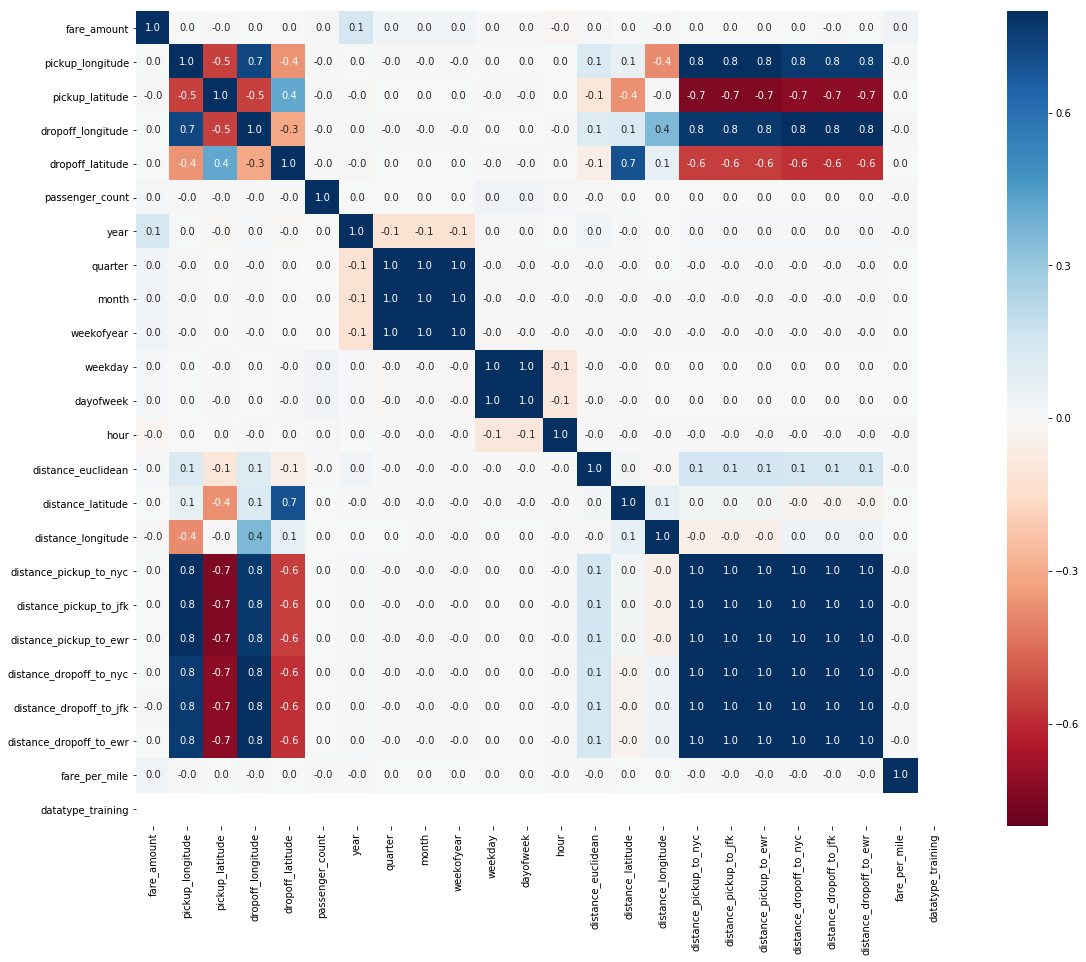

In [24]:
# compute pairwise correlation of columns, excluding NA/null values and present through heat map
corr = df_data[df_data['datatype_training'] == 1].drop(['key'], axis=1).corr()
fig, axes = plt.subplots(figsize=(20, 15))
heatmap = sns.heatmap(corr, annot=True, cmap=plt.cm.RdBu, fmt='.1f', square=True, vmin=-0.8, vmax=0.8)

> **Model, predict and solve the problem**

Now, it is time to feed the features to Machine Learning models.

In [25]:
# select all features
x = df_data[df_data['datatype_training'] == 1].drop(['key', 'pickup_datetime', 'fare_amount', 'fare_per_mile', 'datatype_training'], axis=1)
y = df_data[df_data['datatype_training'] == 1]['fare_amount']

In [26]:
# perform train-test (validate) split
x_train, x_validate, y_train, y_validate = train_test_split(x, y, test_size=0.25, random_state=58)

In [27]:
# random forest regression model setup
model_forestreg = RandomForestRegressor(n_estimators=10, max_depth=20, min_samples_split=1000, random_state=58)

# random forest regression model fit
model_forestreg.fit(x_train, y_train)

# random forest regression model prediction
model_forestreg_ypredict = model_forestreg.predict(x_validate)

# random forest regression model metrics
model_forestreg_rmse = mean_squared_error(y_validate, model_forestreg_ypredict) ** 0.5
model_forestreg_cvscores = np.sqrt(np.abs(cross_val_score(model_forestreg, x, y, cv=5, scoring='neg_mean_squared_error')))
print('random forest regression\n  root mean squared error: %0.4f, cross validation score: %0.4f (+/- %0.4f)' %(model_forestreg_rmse, model_forestreg_cvscores.mean(), 2 * model_forestreg_cvscores.std()))

random forest regression
  root mean squared error: 0.2365, cross validation score: 0.2362 (+/- 0.0013)


> **Supply or submit the results**

Our submission to the competition site Kaggle is ready. Any suggestions to improve our score are welcome.

In [28]:
# model selection
final_model = model_forestreg

# prepare testing data and compute the observed value
x_test = df_data[df_data['datatype_training'] == 0].drop(['key', 'pickup_datetime', 'fare_amount', 'fare_per_mile', 'datatype_training'], axis=1)
y_test = pd.DataFrame(np.expm1(final_model.predict(x_test)), columns=['fare_amount'], index=df_data.loc[df_data['datatype_training'] == 0, 'key'])

In [29]:
# submit the results
out = pd.DataFrame({'key': y_test.index, 'fare_amount': y_test['fare_amount']})
out.to_csv('submission.csv', index=False)